# Sentence Tokenization

<b>Note:</b>
- If the Acts and Joints were mixed for the chosen year, the OCRed output will contain `{year}_Both.txt` and `{year}_Both_data.tsv`
- If the Acts and Joints were seperate for the chosen year, the OCRed output will contain `{year}_Acts.txt` and `{year}_Acts_data.tsv`

In [1]:
from nltk.tokenize import PunktSentenceTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import re

pd.set_option('display.max_colwidth', None)

In [2]:
year = 1901

In [3]:
direc = "../OCRed/" + str(year)

try:
    acts_path = direc + "/" + str(year) + "_Acts.txt"
    with open(acts_path, 'r') as f:
        data = f.read()

    actsSep = True  # A flag to identify if the acts and joints are seperate or if they are joined

# If the directory contains {year}_Both.txt instead
except FileNotFoundError:
    acts_path = direc + "/" + str(year) + "_Both.txt"
    with open(acts_path, 'r') as f:
        data = f.read()
    
    actsSep = False

# This variable holds all the OCRed text as a String
# data

In [4]:
print("The number of pages OCRed for {year} is: {count}".format(year = year, count = (data.count("\n\n")+1)))

The number of pages OCRed for 1901 is: 258


## Training the tokenizer
Based on this [article](https://subscription.packtpub.com/book/application-development/9781782167853/1/ch01lvl1sec12/training-a-sentence-tokenizer),
- NLTK's default sentence tokenizer is general purpose and usually works quite well. But sometimes it might not be the best choice for our text if it uses nonstandard punctuation or is formatted in a unique way. In such cases, training your own sentence tokenizer can result in much more accurate sentence tokenization.
- The `PunktSentenceTokenizer` class uses an unsupervised learning algorithm to learn what constitutes a sentence break.
    - The specific technique used in this case is called sentence boundary detection. It works by counting punctuation and tokens that commonly end a sentence, such as a period or a newline, then using the resulting frequencies to decide the sentence boundaries.

In [5]:
sent_tokenizer = PunktSentenceTokenizer(data)
sentences = sent_tokenizer.tokenize(data)

# A List of tokens/sentences as seperated by nltk's PunktSentenceTokenizer
# sentences

## Creating the dataframe with the sentences and chracter lengths

In [6]:
# Add to a new DataFrame
df = pd.DataFrame()
df["sentence"] = sentences

In [7]:
df["length"] = [len(sentence) for sentence in sentences]
print("Length of the initial dataframe:", df.shape[0], "\nThis is the number of tokenized sentences.")

Length of the initial dataframe: 1864 
This is the number of tokenized sentences.


## Adding page file names
- Add an identifier that specifies which page number that sentence starts on.
- Reading only Acts. <b> Not reading Joints </b>
- The reason to read the files from the directory is to ensure that missing file pages are not missed in the dataframe.

In [8]:
imgs_path = direc + "/images"

imgs = os.listdir(imgs_path)
imgs = [img for img in imgs if "jpg" in img or "tiff" in img or "JPG" in img or "TIFF" in img]
imgs.sort()
print("The number of image files for this year is:", len(imgs))

The number of image files for this year is: 270


In [9]:
fileType = imgs[0].split(".")
fileType = fileType[1]
print(f"The files are of type: .{fileType}")

The files are of type: .jpg


In [13]:
def addPrefix(fileName: str, nameLen: int) -> str:
    '''
    Since the fileNames from the excel parsing could be any of any length
    (ranging from 1-3), this function appends a string of 0's to the 
    start of the input so that it is 5 lengths long.
    
    Parameters
    ----------
    fileName : str
        The file name that needs to be prefixed
    nameLen : int
        The length of the expected name of the file
        Ex. '00034.jpg' would have length of 5

    Returns
    -------
    str
        A length 5 file name (prefixed with 0's)
    '''
    
    # Remove the file type
    name = fileName.split(".")[0]

    prefix_length = nameLen - len(name)
    prefix = "0" * prefix_length
    
    final_string = prefix + fileName
    return final_string

The imgs list, right now, contains both Acts and Joints.
<br>So, partition the imgs list so that it contains only Acts.

In [17]:
# Get the chracter length of the image file
nameLen = len(imgs[0].split(".")[0])

# Read in CopyofImageCorpusMetadata.xlsx to a pandas frame
# The file needs to be in THE SAME direcotry as this file.
corpusMetaPath = "./Copy of ImageCorpusMetadata.xlsx"
corpusMeta = pd.read_excel(corpusMetaPath)

corpusMeta = corpusMeta[corpusMeta["year"] == year]  # Only the row for this year

# Read the value in the "Acts Start Page File Name" column for the year.
ActsFirstPage = str(int(corpusMeta["Acts Start Page File Name"])) + "." + fileType
ActsFirstPage = addPrefix(ActsFirstPage, nameLen)
print("The first page file name for the acts is", ActsFirstPage)

# Read the value in the "Acts Last Page File Name" column for the year.
ActsLastPage = str(int(corpusMeta["Acts Last Page File Name"])) + "." + fileType
ActsLastPage = addPrefix(ActsLastPage, nameLen)
print("The last page file name for the acts is", ActsLastPage)

# Split the imgs list on the values
ActsFirstPage_indx = imgs.index(ActsFirstPage)
ActsLastPage_indx = imgs.index(ActsLastPage)
imgs = imgs[ActsFirstPage_indx:ActsLastPage_indx+1]

The first page file name for the acts is 00035.jpg
The last page file name for the acts is 00292.jpg


<br>

<b>Note:</b>
- The OCR text seperates new pages by adding "\n\n".
- However, most likely, the total number of pages does not equal the total count of "\n\n" in the text as the OCR does not add "\n\n" after every page.
- This can be demonstrated by the code cell below:

In [18]:
print(f"Total number of pages: {ActsLastPage_indx+1 - ActsFirstPage_indx}")

# Find the total count for "\n\n"
count = 0
for i in range(0, df.shape[0]):

    if "\n\n" in df.iloc[i]['sentence']:
        count += 1

print(f"The total count for '\\n\\n' is {count}")

Total number of pages: 258
The total count for '\n\n' is 209


<br>
This can be further demonstrated by adding a page identifier in the dataframe which corresponds to the start page of the sentence.

In [19]:
# Have a list of images, which are basically new page identifiers
# A list of tokenized sentences
# Some tokenized sentences will correspond to the same image

# Create a list for the page numbers
# A new page starts when "\n\n" appears in the sentences

df['page'] = np.nan

# Track the index for the imgs list. 
imgs_trk = 0

for i in range(0, df.shape[0]):

    if "\n\n" in df.iloc[i]['sentence'] and i != 0:
        df.at[i, 'page'] = imgs[imgs_trk]

        # if this is the first iteration, then don't increment
        # the list tracker as the first sentence always "\n\n"
        if i != 0:
            imgs_trk += 1

    else:
        df.at[i, 'page'] = imgs[imgs_trk]

By checking the end with of the table with `df.tail()`, we see that the last page values do not correspond with the last page file name for the acts.

In [20]:
df.tail()

,sentence,length,page
1859,"SECTION 1. Be it enacted by the General Assembly of the State of South Carolina: That the County Board of Commis- sioners of Cherokee County be, and they are hereby, authorized, if in their discretion they deem that it is for the best interest of said County, to borrow a sum of money from the Sinking Fund of the State of South Carolina, not to exceed ten thousand dol- lars, at a rate of interest not to exceed five per centum per an- num, for the purpose of building a bridge across Broad River, in said County, at such point on said river as they may deem most practicable, and a special tax of one-half mill on the dollar may be levied on all taxable property in the County of Chero- kee, provided the Board of Commissioners so decide to build said bridge, for the said period of seven years, for the purpose of repaying said loan.",836,00243.jpg
1860,"That the proceeds of said levy of one- half mill shall be paid each year on said loan until the seventh year, in which year the balance remaining due on said loan shall be paid from said special levy, if any remain it shall-be turned into the County Treasury for ordinary County purposes, and if a’sufficient sum has not been realized by said special levy at the expiration of said seven years the deficiency shall be paid by the County Board of Commissioners out of the ordinary County funds.",493,00243.jpg
1861,Sec. 2.,7,00243.jpg
1862,"That the Commissioners of the Sinking Fund of the State of South Carolina are hereby authorized to lend to the County Board of Commissioners of Cherokee County out of the funds in their hands, the sum of ten thousand dollars, to be used for building said bridge, said sum to be secured by the special levy as herein provided for in Section one.",344,00243.jpg
1863,"Approved the 2oth day of February, A. D. 1goI.",46,00243.jpg


<br>

One way to eliminate this issue is by utilizing the `{year}_Both_data.tsv` (if acts and joints mixed) or `{year}_Acts_data.tsv` (if acts and joints seperated) file from the OCR output.
<br>This file contains each word (in the 2nd last column) and the filename for that word (last column).

In [21]:
if actsSep:
    df_words = pd.read_table(f"{direc}/{year}_Acts_data.tsv")
else:
    df_words = pd.read_table(f"{direc}/{year}_Both_data.tsv")

df_words

,left,top,width,height,conf,text,name
0,0,0,1592,2536,-1.000000,NaN,00035.jpg
1,728,283,60,144,-1.000000,NaN,00035.jpg
2,728,257,180,170,-1.000000,NaN,00035.jpg
3,728,283,60,144,-1.000000,NaN,00035.jpg
4,728,283,60,144,34.161140,IK,00035.jpg
...,...,...,...,...,...,...,...
127981,682,1851,38,31,95.772659,of,00292.jpg
127982,735,1851,174,39,96.576187,"February,",00292.jpg
127983,926,1851,40,31,92.059761,A.,00292.jpg
127984,984,1851,39,31,92.059761,D.,00292.jpg


<br>
So, to label the page numbers in the dataframe, we can go through the original dataframe and find the start and end words in each sentence.
<br>We, can then find the page numbers for those words, from `df_words` and add them to the original dataframe, `df`.

<br>To start, we need to clean the two dataframes.

In [22]:
# Drop the columns which are unessecary for our analysis
df_words.drop(columns=["left", "top", "width", "height", "conf"], inplace=True)

# Drop the rows which don't contain a word in the "text" column
df_words.dropna(inplace=True)

# Relabel the "name" column to "page" column
df_words.rename(columns={"name": "page"}, inplace=True)

# Reassign index after dropping nas
df_words = df_words.assign(row_number=range(len(df_words)))
df_words.set_index('row_number', inplace=True)

# Drop the 'page' column from the org dataframe
df.drop(columns=['page'], inplace=True)

# Add an empty 'start_page' and 'end_page' column
df['start_page'] = np.nan
df['end_page'] = np.nan

Since, a word can only exist on a single page, we can have unique identifiers for the start and end page for each sentence 

In [23]:
# Tracker for df_words:
words_trkr = 0

# Loop over the original dataframe
for i in range(0, df.shape[0]):
    
    # Remove "\n\n" from the original dataframe as they will interfere with the analysis
    df.at[i, 'sentence'] = df.iloc[i]['sentence'].replace("\n\n", "")

    # For each sentence, extract the first and last word
    tmp_sentence = df.iloc[i]['sentence'].split(" ")
    first, last = tmp_sentence[0], tmp_sentence[-1]

    # Get the page number for the start and end word
    first_page = df_words.iloc[words_trkr]['page']

    try:
        end_page = df_words.iloc[words_trkr + len(tmp_sentence)]['page']
    except:
        end_page = df_words.iloc[words_trkr]['page']
    
    # Assign the page number to their respective columns in the dataframe
    df.at[i, 'start_page'] = first_page
    df.at[i, 'end_page'] = end_page
    
    # Update tracker
    words_trkr += len(tmp_sentence)

In [24]:
df.tail(10)

,sentence,length,start_page,end_page
1854,"Approved the 19th day of February, A. D. Igor. No.",50,00290.jpg,00290.jpg
1855,"497. AN ACT to AvuTHOoRIZE AND EMPOWER Twin City Power CoMPANY, A CORPORATION OF THE STATE OF SOUTH CaRo- LINA TO CONSTRUCT A DAM OR DaMs ACROSS THE SAVAN- NAH RIVER TO THE GEORGIA STATE LINE, IN Sarp River, NEAR THE MOUTH OF DortTon’s CREEK AND SOUTHERN Enp or Price’s ISLAND, AND TO CONFER THE RIGHT OF EMINENT DOMAIN ON SAID COMPANY.",336,00290.jpg,00290.jpg
1856,"Whereas Twin City Power Company has been duly organ- ized under the laws of the State of South Carolina for the pur- pose of developing electrical power by means of the construc- tion of a dam or dams across the Savannah River and for the erection and operation of certain industries in the charter of said Company mentioned and set forth and it is necessary to have the power and authority to construct a dam or dams across said River at or near the mouth of Dorton’s Creek and southern end of Price’s Island in the Savannah River for the collection of sufficient water to operate such machinery for manufacturing and other purposes ; And whereas, by the construction of said dam or dams it will raise the water in said river so as to affect and overflow.",758,00290.jpg,00291.jpg
1857,"lands adjacent to said River; And whereas by the construction of said dam or dams the navigation of said River may be increased and the public in- terest promoted by the construction thereof for the purpose and for the sake of such improvement in the navigability of said River and for the public purposes to be ,fulfilled and encour- aged by the construction of said dam or dams and for the pur- pose of removing any doubt which may arise as to the power and authority of the Secretary of State in granting the charter to the said Twin City Power Company for the erection of said dam or dams to be built across the said River: Now, Section 1. Be it enacted by the General Assembly of the State of South Carolina: That the right, power and privilege to construct and maintain a dam or dams across the Savannah River, as hereinbefore mentioned, to Twin City Power Com- pany, its successors or assigns, shall be and is hereby fully au- thorized, ratified and confirmed; and that the said Twin City Power Company shall have all rights, powers and privileges conferred for the purpose of the acquisition and condemnation of land which may be overflowed by the erection or construction of said dam or dams as are conferred by Sections 1743-1755, in- clusive, of the Revised Statutes of South Carolina, 1893, upon railway, canal and turnpike companies in the State and all of the Acts amendatory thereof; it being the intention of this Act for the sake of the public purposes intended to be carried out by said company to confer upon it all the rights, privileges and authorities conferred by the laws of this State upon rail- way, canal and turnpike companies in the acquisition and con- demnation of property for rights of way or other interests in lands.",1751,00291.jpg,00291.jpg
1858,"Approved the 2oth day of February, A. D. 1901 AN ACT To EMPOWER AND AUTHORIZE THE CouNnTY BoarD oF COMMISSIONERS OF CHEROKEE COUNTY TO BUILD A BRIDGE ACROSS BroAaD RIVER AND Borrow MONEY THERE- FOR FROM THE CoMMISSIONERS OF THE SINKING FUND.",243,00291.jpg,00292.jpg
1859,"SECTION 1. Be it enacted by the General Assembly of the State of South Carolina: That the County Board of Commis- sioners of Cherokee County be, and they are hereby, authorized, if in their discretion they deem that it is for the best interest of said County, to borrow a sum of money from the Sinking Fund of the State of South Carolina, not to exceed ten thousand dol- lars, at a rate of interest not to exceed five per centum per an- num, for the purpose of building a bridge across Broad River, in said County, at such point on said river as they may deem most practicable, and a special tax of one-half mill on the dollar may be levied on all taxable propert

## Cleaning on Char. lenght
Get rid of sentences with a low number of characters as they might not form meaningful sentences

However, first, get the statistics on the length column to avoid removing meaningful sentence

In [25]:
# Get the statistics for the length column
df["length"].describe()

count    1864.000000
mean      295.813305
std       375.065698
min         1.000000
25%        47.000000
50%       188.000000
75%       391.000000
max      3650.000000
Name: length, dtype: float64

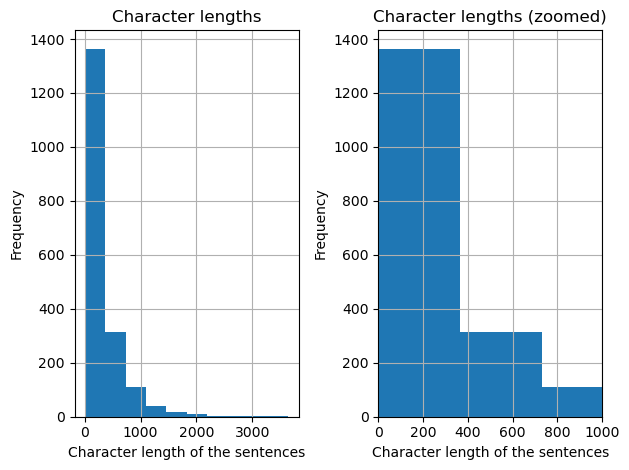

In [26]:
# Plot a histogram for that column
fig, axes = plt.subplots(1, 2)
df.hist(column="length", ax=axes[0])
axes[0].set_title('Character lengths')
axes[0].set(xlabel="Character length of the sentences", ylabel="Frequency")

df.hist(column="length", ax=axes[1])

axes[1].set_title('Character lengths (zoomed)')
axes[1].set(xlabel="Character length of the sentences", ylabel="Frequency", xlim = [0, 1000])
fig.tight_layout()

Create a smaller dataframe, and export it to csv, that only contains the short length sentences.
Check the csv and change the length condition accordingly.

In [27]:
testing_df = df[df['length'] < 13]
testing_df.to_csv(f"{year}_len_testing.csv")

<br>
Once, the length is decided, create a new dataframe with sentences greater that the length

In [28]:
df_cleaned = df[ df["length"] > 13]
print("Length of the cleaned dataframe: ", df_cleaned.shape[0])
print("Reduction of about {:.2f}%".format( (1 - df_cleaned.shape[0]/df.shape[0]) * 100))

Length of the cleaned dataframe:  1478
Reduction of about 20.71%


In [29]:
df_cleaned

,sentence,length,start_page,end_page
0,IK OF THE | GENERAL ASSEMBLY.,31,00035.jpg,00035.jpg
1,"OF THE STATE OF SOUTH CAROLINA Passed at the Regular Session which was begun and held at the City of Co- lumbia on the Eighth Day of January, A. D. 1961 and was adjourned without day on the Sicteenth day of February, A. D. 1901.",228,00035.jpg,00035.jpg
2,"M. B. McSweeney, Governor.",26,00035.jpg,00035.jpg
3,"Jas. H. TittMan, Lieutenant- Governor and ex officio President of the Senate.",77,00035.jpg,00035.jpg
4,"W. F STEVENSON, Speaker of the House of Representatives Rorert R. HEMPHILL, Clerk of the Senate.",96,00035.jpg,00035.jpg
...,...,...,...,...
1858,"Approved the 2oth day of February, A. D. 1901 AN ACT To EMPOWER AND AUTHORIZE THE CouNnTY BoarD oF COMMISSIONERS OF CHEROKEE COUNTY TO BUILD A BRIDGE ACROSS BroAaD RIVER AND Borrow MONEY THERE- FOR FROM THE CoMMISSIONERS OF THE SINKING FUND.",243,00291.jpg,00292.jpg
1859,"SECTION 1. Be it enacted by the General Assembly of the State of South Carolina: That the County Board of Commis- sioners of Cherokee County be, and they are hereby, authorized, if in their discretion they deem that it is for the best interest of said County, to borrow a sum of money from the Sinking Fund of the State of South Carolina, not to exceed ten thousand dol- lars, at a rate of interest not to exceed five per centum per an- num, for the purpose of building a bridge across Broad River, in said County, at such point on said river as they may deem most practicable, and a special tax of one-half mill on the dollar may be levied on all taxable property in the County of Chero- kee, provided the Board of Commissioners so decide to build said bridge, for the said period of seven years, for the purpose of repaying said loan.",836,00292.jpg,00292.jpg
1860,"That the proceeds of said levy of one- half mill shall be paid each year on said loan until the seventh year, in which year the balance remaining due on said loan shall be paid from said special levy, if any remain it shall-be turned into the County Treasury for ordinary County purposes, and if a’sufficient sum has not been realized by said special levy at the expiration of said seven years the deficiency shall be paid by the County Board of Commissioners out of the ordinary County funds.",493,00292.jpg,00292.jpg
1862,"That the Commissioners of the Sinking Fund of the State of South Carolina are hereby authorized to lend to the County Board of Commissioners of Cherokee County out of the funds in their hands, the sum of ten thousand dollars, to be used for building said bridge, said sum to be secured by the special levy as herein provided for in Section one.",344,00292.jpg,00292.jpg


In [30]:
# Export the final dataframe to csv for viewing
df_cleaned.to_csv(f"{year}.csv", index=False)